In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import warnings

import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    fbeta_score,
    f1_score,
    make_scorer,
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from xgboost import XGBClassifier

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [4]:
feat_30_loc = "../data/features_30_sec.csv"
feat_3_loc = "../data/features_3_sec.csv"

<IPython.core.display.Javascript object>

In [5]:
# named long and short to differentiate easier
long = pd.read_csv(feat_30_loc)
short = pd.read_csv(feat_3_loc)

<IPython.core.display.Javascript object>

In [6]:
long.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


<IPython.core.display.Javascript object>

In [7]:
short.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


<IPython.core.display.Javascript object>

In [8]:
long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1000 non-null   object 
 1   length                   1000 non-null   int64  
 2   chroma_stft_mean         1000 non-null   float64
 3   chroma_stft_var          1000 non-null   float64
 4   rms_mean                 1000 non-null   float64
 5   rms_var                  1000 non-null   float64
 6   spectral_centroid_mean   1000 non-null   float64
 7   spectral_centroid_var    1000 non-null   float64
 8   spectral_bandwidth_mean  1000 non-null   float64
 9   spectral_bandwidth_var   1000 non-null   float64
 10  rolloff_mean             1000 non-null   float64
 11  rolloff_var              1000 non-null   float64
 12  zero_crossing_rate_mean  1000 non-null   float64
 13  zero_crossing_rate_var   1000 non-null   float64
 14  harmony_mean             

<IPython.core.display.Javascript object>

In [9]:
short.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 9990 non-null   object 
 1   length                   9990 non-null   int64  
 2   chroma_stft_mean         9990 non-null   float64
 3   chroma_stft_var          9990 non-null   float64
 4   rms_mean                 9990 non-null   float64
 5   rms_var                  9990 non-null   float64
 6   spectral_centroid_mean   9990 non-null   float64
 7   spectral_centroid_var    9990 non-null   float64
 8   spectral_bandwidth_mean  9990 non-null   float64
 9   spectral_bandwidth_var   9990 non-null   float64
 10  rolloff_mean             9990 non-null   float64
 11  rolloff_var              9990 non-null   float64
 12  zero_crossing_rate_mean  9990 non-null   float64
 13  zero_crossing_rate_var   9990 non-null   float64
 14  harmony_mean            

<IPython.core.display.Javascript object>

In [10]:
long.isna().sum()

filename                   0
length                     0
chroma_stft_mean           0
chroma_stft_var            0
rms_mean                   0
rms_var                    0
spectral_centroid_mean     0
spectral_centroid_var      0
spectral_bandwidth_mean    0
spectral_bandwidth_var     0
rolloff_mean               0
rolloff_var                0
zero_crossing_rate_mean    0
zero_crossing_rate_var     0
harmony_mean               0
harmony_var                0
perceptr_mean              0
perceptr_var               0
tempo                      0
mfcc1_mean                 0
mfcc1_var                  0
mfcc2_mean                 0
mfcc2_var                  0
mfcc3_mean                 0
mfcc3_var                  0
mfcc4_mean                 0
mfcc4_var                  0
mfcc5_mean                 0
mfcc5_var                  0
mfcc6_mean                 0
mfcc6_var                  0
mfcc7_mean                 0
mfcc7_var                  0
mfcc8_mean                 0
mfcc8_var     

<IPython.core.display.Javascript object>

In [11]:
short.isna().sum()

filename                   0
length                     0
chroma_stft_mean           0
chroma_stft_var            0
rms_mean                   0
rms_var                    0
spectral_centroid_mean     0
spectral_centroid_var      0
spectral_bandwidth_mean    0
spectral_bandwidth_var     0
rolloff_mean               0
rolloff_var                0
zero_crossing_rate_mean    0
zero_crossing_rate_var     0
harmony_mean               0
harmony_var                0
perceptr_mean              0
perceptr_var               0
tempo                      0
mfcc1_mean                 0
mfcc1_var                  0
mfcc2_mean                 0
mfcc2_var                  0
mfcc3_mean                 0
mfcc3_var                  0
mfcc4_mean                 0
mfcc4_var                  0
mfcc5_mean                 0
mfcc5_var                  0
mfcc6_mean                 0
mfcc6_var                  0
mfcc7_mean                 0
mfcc7_var                  0
mfcc8_mean                 0
mfcc8_var     

<IPython.core.display.Javascript object>

In [12]:
X = short.drop(["filename", "label"], 1)
y = short["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=34, stratify=y
)

<IPython.core.display.Javascript object>

In [13]:
print_vif(X)

VIF results
-------------------------------
length                     2703.515224
chroma_stft_mean              4.118726
chroma_stft_var               2.526067
rms_mean                     51.227912
rms_var                       3.840067
spectral_centroid_mean      185.494010
spectral_centroid_var        20.730610
spectral_bandwidth_mean      77.964079
spectral_bandwidth_var        6.843537
rolloff_mean                118.856952
rolloff_var                  15.139926
zero_crossing_rate_mean      26.767622
zero_crossing_rate_var        8.054137
harmony_mean                  1.487883
harmony_var                  15.550854
perceptr_mean                 1.595504
perceptr_var                  9.233448
tempo                         1.014670
mfcc1_mean                   19.701721
mfcc1_var                     2.138339
mfcc2_mean                   20.273645
mfcc2_var                     4.009512
mfcc3_mean                    5.610340
mfcc3_var                     2.204361
mfcc4_mean          

<IPython.core.display.Javascript object>

In [14]:
model = XGBClassifier(n_jobs=-1)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

<IPython.core.display.Javascript object>

In [15]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 0.9993743743743744
Test score: 0.8948948948948949


<IPython.core.display.Javascript object>

In [16]:
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[187   0   2   3   0   2   4   0   1   1]
 [  0 191   1   0   0   8   0   0   0   0]
 [  8   0 174   4   0   6   0   1   4   2]
 [  1   0   0 181   1   2   1   1   4   9]
 [  2   1   1   3 185   0   0   4   3   1]
 [  4   6   9   0   0 179   0   1   1   0]
 [  3   0   1   0   1   2 184   0   1   8]
 [  0   1   3   8   2   2   0 175   6   3]
 [  8   1   4   4   1   1   0   4 175   2]
 [  8   3   9   8   3   1   5   0   5 157]]
              precision    recall  f1-score   support

       blues       0.85      0.94      0.89       200
   classical       0.94      0.95      0.95       200
     country       0.85      0.87      0.86       199
       disco       0.86      0.91      0.88       200
      hiphop       0.96      0.93      0.94       200
        jazz       0.88      0.90      0.89       200
       metal       0.95      0.92      0.93       200
         pop       0.94      0.88      0.91       200
      reggae       0.88      0.88      0.88       200
        rock       0.86     

<IPython.core.display.Javascript object>

In [17]:
model.feature_importances_

array([0.        , 0.03800463, 0.03463377, 0.01645274, 0.0324426 ,
       0.0168698 , 0.020021  , 0.06190079, 0.01137342, 0.01983152,
       0.03433336, 0.02166527, 0.00872884, 0.0202997 , 0.02400179,
       0.02356387, 0.07974766, 0.02225431, 0.02192752, 0.03419622,
       0.01557651, 0.00555026, 0.01365384, 0.01762722, 0.03462204,
       0.01254063, 0.01411457, 0.01928234, 0.0188738 , 0.01254374,
       0.01244833, 0.02148426, 0.01025447, 0.01234402, 0.0201386 ,
       0.01144201, 0.00941538, 0.01273658, 0.01463784, 0.00444446,
       0.02006706, 0.01022467, 0.01050745, 0.00698193, 0.00834876,
       0.00579647, 0.00754038, 0.00504462, 0.00927337, 0.00763212,
       0.01116396, 0.00437738, 0.01076752, 0.00891686, 0.00714137,
       0.01097579, 0.00929997, 0.00996059], dtype=float32)

<IPython.core.display.Javascript object>

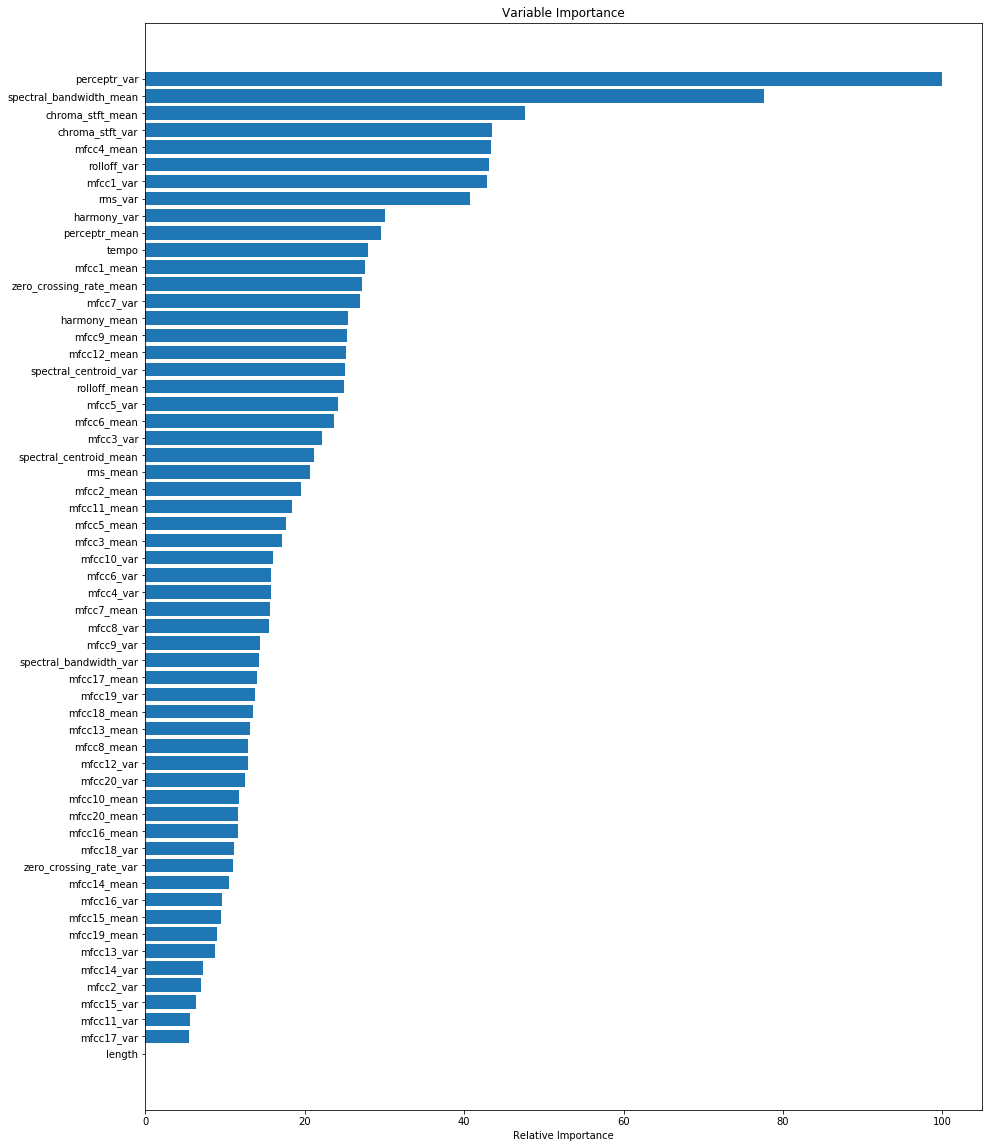

<IPython.core.display.Javascript object>

In [18]:
feature_importance = model.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5


plt.figure(figsize=(15, 20))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

In [19]:
cc_var_cols = [f"mfcc{x}_var" for x in range(1, 21)]
logged_cc_var_df = short.copy()
for col in cc_var_cols:
    logged_cc_var_df[col + "_logged"] = np.log(logged_cc_var_df[col])
    logged_cc_var_df = logged_cc_var_df.drop(col, 1)

<IPython.core.display.Javascript object>

In [20]:
m_start = 12
mel_freq_drops = [f"mfcc{x}_mean" for x in range(m_start, 21)] + [
    f"mfcc{x}_var_logged" for x in range(m_start, 21)
]

<IPython.core.display.Javascript object>

In [21]:
drop_cols = [
    "length",
    "filename",
    "label",
    #     "zero_crossing_rate_mean",
    #     "zero_crossing_rate_var",
    "rolloff_mean",
    "harmony_var",
    "rolloff_var",
    "spectral_centroid_var",
    "spectral_bandwidth_var",
    "spectral_centroid_mean",
    "spectral_bandwidth_mean",
    #     "rms_mean",
    #     "rms_var",
]
drop_cols = drop_cols + mel_freq_drops
print_vif(logged_cc_var_df.drop(drop_cols, 1,))

VIF results
-------------------------------
const                      776.274686
chroma_stft_mean             3.391661
chroma_stft_var              2.546500
rms_mean                     7.666024
rms_var                      3.268666
zero_crossing_rate_mean      6.949903
zero_crossing_rate_var       2.660002
harmony_mean                 1.478593
perceptr_mean                1.573693
perceptr_var                 4.918247
tempo                        1.009578
mfcc1_mean                   7.258845
mfcc2_mean                   5.652443
mfcc3_mean                   2.547365
mfcc4_mean                   2.076686
mfcc5_mean                   2.679961
mfcc6_mean                   3.340509
mfcc7_mean                   3.014978
mfcc8_mean                   3.704902
mfcc9_mean                   2.584736
mfcc10_mean                  2.548987
mfcc11_mean                  2.098440
mfcc1_var_logged             2.949586
mfcc2_var_logged             2.583133
mfcc3_var_logged             2.590872
mfcc4_

<IPython.core.display.Javascript object>

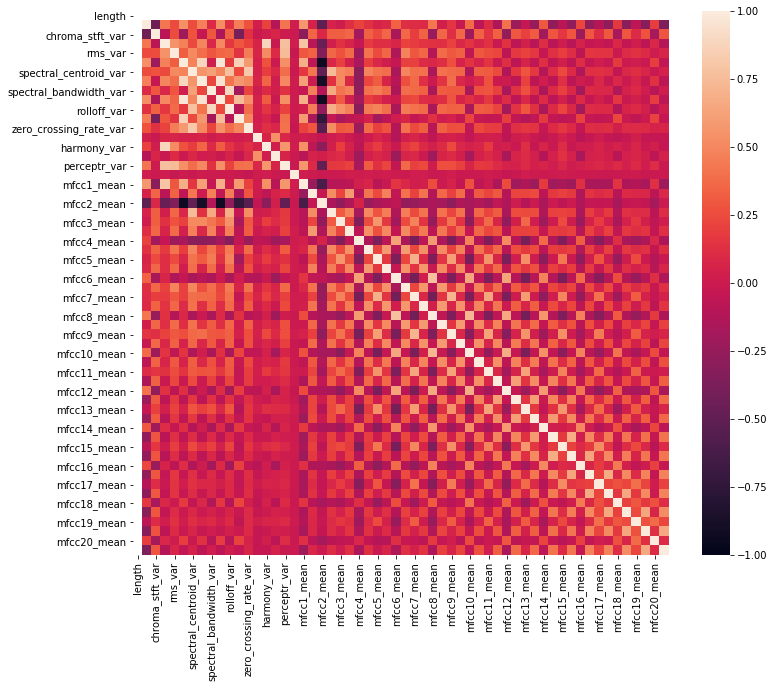

<IPython.core.display.Javascript object>

In [22]:
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), vmin=-1, vmax=1)

In [23]:
X = logged_cc_var_df.drop(drop_cols, 1,)
y = logged_cc_var_df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=34, stratify=y
)

<IPython.core.display.Javascript object>

In [24]:
model = XGBClassifier(n_jobs=-1)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

<IPython.core.display.Javascript object>

In [25]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 0.9993743743743744
Test score: 0.8873873873873874


<IPython.core.display.Javascript object>

In [26]:
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[188   0   2   3   0   2   2   0   2   1]
 [  0 191   1   0   0   7   0   0   0   1]
 [ 10   0 172   2   0   6   0   1   5   3]
 [  3   0   3 178   2   0   1   2   3   8]
 [  4   1   1   4 180   0   0   3   5   2]
 [  2   4   5   0   0 186   1   1   1   0]
 [  6   0   2   0   1   2 179   0   3   7]
 [  0   1   9   2   3   2   0 171   8   4]
 [  6   0   3   6   5   1   0   2 176   1]
 [  7   3  14   8   4   1   4   1   5 152]]
              precision    recall  f1-score   support

       blues       0.83      0.94      0.88       200
   classical       0.95      0.95      0.95       200
     country       0.81      0.86      0.84       199
       disco       0.88      0.89      0.88       200
      hiphop       0.92      0.90      0.91       200
        jazz       0.90      0.93      0.91       200
       metal       0.96      0.90      0.93       200
         pop       0.94      0.85      0.90       200
      reggae       0.85      0.88      0.86       200
        rock       0.85     

<IPython.core.display.Javascript object>

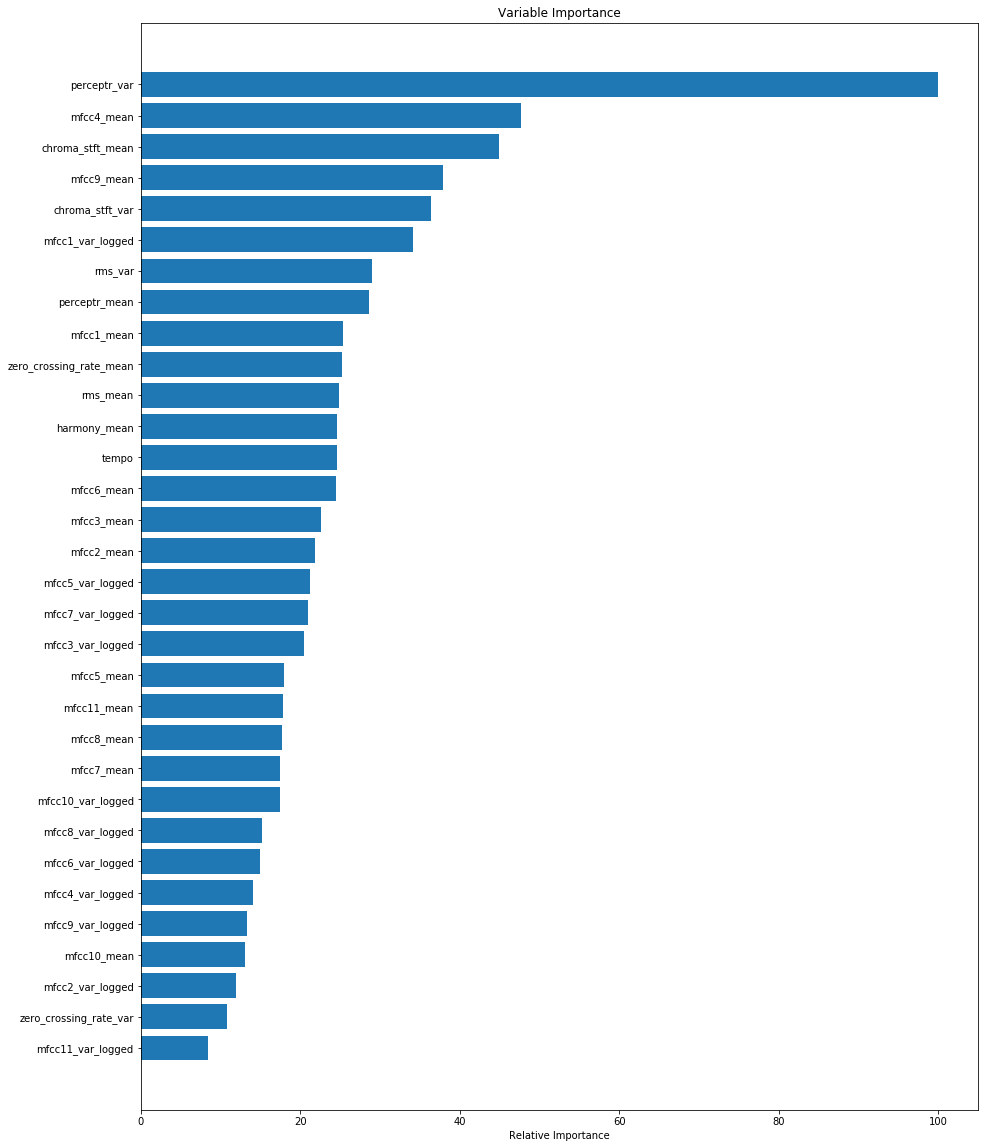

<IPython.core.display.Javascript object>

In [27]:
feature_importance = model.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5


plt.figure(figsize=(15, 20))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

In [31]:
list(X.columns)

['chroma_stft_mean',
 'chroma_stft_var',
 'rms_mean',
 'rms_var',
 'zero_crossing_rate_mean',
 'zero_crossing_rate_var',
 'harmony_mean',
 'perceptr_mean',
 'perceptr_var',
 'tempo',
 'mfcc1_mean',
 'mfcc2_mean',
 'mfcc3_mean',
 'mfcc4_mean',
 'mfcc5_mean',
 'mfcc6_mean',
 'mfcc7_mean',
 'mfcc8_mean',
 'mfcc9_mean',
 'mfcc10_mean',
 'mfcc11_mean',
 'mfcc1_var_logged',
 'mfcc2_var_logged',
 'mfcc3_var_logged',
 'mfcc4_var_logged',
 'mfcc5_var_logged',
 'mfcc6_var_logged',
 'mfcc7_var_logged',
 'mfcc8_var_logged',
 'mfcc9_var_logged',
 'mfcc10_var_logged',
 'mfcc11_var_logged']

<IPython.core.display.Javascript object>

In [39]:
num_cols = list(X.columns)

bin_cols = []

cat_cols = []
drop_cats = []


preprocessing = ColumnTransformer(
    [
        # Scale numeric columns (not needed for all models but can't hurt)
        ("scaler", StandardScaler(), num_cols)
    ],
    remainder="passthrough",
)


pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        # Choose your model and put it here
        ("svc", SVC()),
    ]
)


grid = {
    # Use model__ with hyperprammeter names after
    "svc__C": [1, 10],
    "svc__kernel": ["linear", "rbf"],
    "svc__decision_function_shape": ["ovo", "ovr"],
    #     "svc__degree": [2, 3, 5],
}


pipeline_cv = GridSearchCV(pipeline, grid, verbose=1, n_jobs=-1, cv=2)
pipeline_cv.fit(X_train, y_train)


print(pipeline_cv.score(X_train, y_train))
print(pipeline_cv.score(X_test, y_test))

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    8.6s finished


0.9924924924924925
0.9009009009009009


<IPython.core.display.Javascript object>

In [40]:
pipeline_cv.best_params_

{'svc__C': 10, 'svc__decision_function_shape': 'ovo', 'svc__kernel': 'rbf'}

<IPython.core.display.Javascript object>